# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [209]:
import math
import random
import time
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchviz


In [210]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


(100, 1) (100, 1)


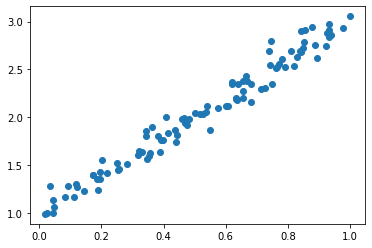

In [211]:
torch.manual_seed(42)

N = 100
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(N, 1)

print(x.shape, y.shape)
plt.scatter(x, y)

In [91]:
train_index = math.floor(N * .8)
x_train, y_train = x[:train_index], y[:train_index]
x_validation, y_validation = x[train_index:], y[train_index:]

# Create tensor from numpy
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

x_validation_tensor = torch.from_numpy(x_validation).float().to(device)
y_validation_tensor = torch.from_numpy(y_validation).float().to(device)

In [212]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [213]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return len(self.x)

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
train_data = TensorDataset(x_train_tensor, y_train_tensor)


0.194019, 0.139138


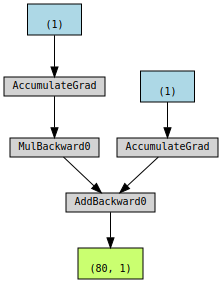

In [214]:
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

x_validation_tensor = torch.from_numpy(x_validation).float().to(device)
y_validation_tensor = torch.from_numpy(y_validation).float().to(device)


a_tensor = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b_tensor = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print("%f, %f" % (a_tensor, b_tensor))
n_epoch = 500

q = deque(maxlen=n_epoch)

y_hat_tensor = b_tensor * x_train_tensor + a_tensor
torchviz.make_dot(y_hat_tensor)

In [215]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        return loss.item()
    
    return train_step

In [216]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        return self.a + self.b * x
    

In [217]:
lr = .2
n_epochs = 500
show_every = 50
data_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

model = MyModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train_step = make_train_step(model, loss_fn, optimizer)
for i in range(n_epoch):
    loss = train_step(x_train_tensor , y_train_tensor)
    if i % show_every == 0:
        print("i: %d, loss: %f, a: %.2f, b: %.2f" % (i, loss, model.a, model.b))



i: 0, loss: 3.711195, a: 1.83, b: 2.38
i: 50, loss: 0.009116, a: 1.01, b: 2.01
i: 100, loss: 0.009113, a: 1.01, b: 2.02
i: 150, loss: 0.009113, a: 1.01, b: 2.02
i: 200, loss: 0.009113, a: 1.01, b: 2.02
i: 250, loss: 0.009113, a: 1.01, b: 2.02
i: 300, loss: 0.009113, a: 1.01, b: 2.02
i: 350, loss: 0.009113, a: 1.01, b: 2.02
i: 400, loss: 0.009113, a: 1.01, b: 2.02
i: 450, loss: 0.009113, a: 1.01, b: 2.02


In [127]:
lr = .2
n_epochs = 500
show_every = 50

model = nn.Sequential(nn.Linear(1, 1)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
train_step = make_train_step(model, loss_fn, optimizer)
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

for i in range(n_epoch):
    loss = train_step(x_train_tensor , y_train_tensor)
    if i % show_every == 0:
        params = list(model.parameters())
        print("i: %d, loss: %f, a: %.2f, b: %.2f" % (i, loss, params[0].item(), params[1].item()))

i: 0, loss: 6.703701, a: 0.69, b: 0.32
i: 50, loss: 0.013063, a: 1.80, b: 1.11
i: 100, loss: 0.009391, a: 1.96, b: 1.04
i: 150, loss: 0.009139, a: 2.00, b: 1.02
i: 200, loss: 0.009120, a: 2.01, b: 1.01
i: 250, loss: 0.009119, a: 2.02, b: 1.01
i: 300, loss: 0.009119, a: 2.02, b: 1.01
i: 350, loss: 0.009119, a: 2.02, b: 1.01
i: 400, loss: 0.009119, a: 2.02, b: 1.01
i: 450, loss: 0.009119, a: 2.02, b: 1.01


i: 0, loss: 0.999875, a: 1.64, b: 1.14
i: 10, loss: 1.071985, a: 2.04, b: 1.03
i: 20, loss: 1.090605, a: 2.01, b: 0.96
i: 30, loss: 0.889501, a: 2.10, b: 1.10
i: 40, loss: 0.628967, a: 2.00, b: 1.10
i: 50, loss: 0.707199, a: 2.06, b: 1.18
i: 60, loss: 1.701509, a: 2.11, b: 1.09
i: 70, loss: 1.736986, a: 2.01, b: 1.06
i: 80, loss: 1.949464, a: 2.12, b: 1.08
i: 90, loss: 0.524308, a: 2.04, b: 1.07
OrderedDict([('0.weight', tensor([[2.0127]], device='cuda:0')), ('0.bias', tensor([0.9599], device='cuda:0'))])


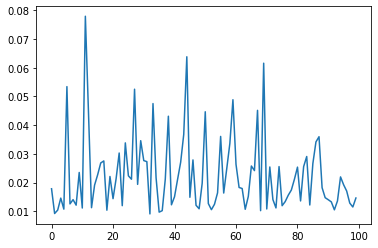

In [208]:
lr = .2
n_epochs = 100
show_every = 10

losses = []
val_losses = []

model = nn.Sequential(nn.Linear(1, 1)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
train_step = make_train_step(model, loss_fn, optimizer)

for i in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    if i % show_every == 0:
        params = list(model.parameters())
        print("i: %d, loss: %f, a: %.2f, b: %.2f" % (i, loss, params[0].item(), params[1].item()))
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()
            
            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())
        
# plt.plot(losses)
plt.plot(val_losses)
print(model.state_dict())

In [69]:
optimizer = optim.SGD([a_tensor, b_tensor], lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

for i in range(n_epoch):
    y_hat_tensor = b_tensor * x_train_tensor + a_tensor
    error_tensor = y_train_tensor - y_hat_tensor
    loss_tensor = loss_fn(y_train_tensor, y_hat_tensor)

    loss_tensor.backward()
    optimizer.step()
    optimizer.zero_grad()
    
print("\rloss: %f, a: %.2f, b: %.2f" % (loss_tensor, a_tensor, b_tensor), end='')



loss: 0.008339, a: 1.02, b: 1.95

## Non-linear

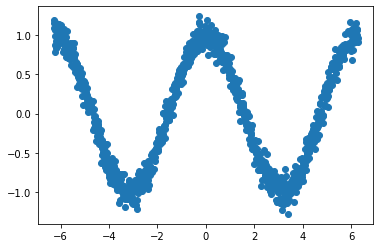

In [295]:
# dataset

torch.manual_seed(42)

step = 1000
x = torch.linspace(-2 * np.pi, 2 * np.pi, step).unsqueeze(1)
y = torch.cos(x) + .1 * torch.randn(step, 1)

plt.scatter(x, y)

x = x.float()
y = y.float()

dataset = TensorDataset(x, y)
num_train = math.floor(step * .8)
num_validation = step - num_train
r = .2
theta = torch.linspace(-1, 1, step).unsqueeze(1)
x = torch.sin(r * theta) * theta / 2
y = torch.cos(r * theta) * theta / 2
num_train
train_data, validation_data = random_split(dataset, [num_train, num_validation])
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=num_validation)


In [307]:
num_hidden = 64
lr = .01
n_epochs = 1000
show_every = 50

model = nn.Sequential(
    nn.Linear(1, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, 1),
).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
train_step = make_train_step(model, loss_fn, optimizer)

losses = []
validation_losses = []
for i in range(n_epochs):
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        loss = train_step(x, y)
        losses.append(loss)

    with torch.no_grad():
        for x, y in validation_loader:
            x = x.to(device)
            y = y.to(device)
            
            model.eval()
            
            y_hat = model(x)
            validation_loss = loss_fn(y, y_hat)
            validation_losses.append(validation_loss.item())

    if i % show_every == 0:
        print("i: %d, train loss: %f, validation loss: %f" % (i, loss, validation_loss))



i: 0, train loss: 0.265230, validation loss: 0.237315
i: 50, train loss: 0.011798, validation loss: 0.014242
i: 100, train loss: 0.015475, validation loss: 0.025355
i: 150, train loss: 0.019669, validation loss: 0.013035
i: 200, train loss: 0.019838, validation loss: 0.018598
i: 250, train loss: 0.016663, validation loss: 0.013330
i: 300, train loss: 0.010785, validation loss: 0.011961
i: 350, train loss: 0.015241, validation loss: 0.011654
i: 400, train loss: 0.010632, validation loss: 0.011388
i: 450, train loss: 0.011192, validation loss: 0.010840
i: 500, train loss: 0.014010, validation loss: 0.013296
i: 550, train loss: 0.015042, validation loss: 0.012254
i: 600, train loss: 0.020244, validation loss: 0.013135
i: 650, train loss: 0.020770, validation loss: 0.013139
i: 700, train loss: 0.013434, validation loss: 0.011883
i: 750, train loss: 0.010635, validation loss: 0.013300
i: 800, train loss: 0.013058, validation loss: 0.012195
i: 850, train loss: 0.016642, validation loss: 0.01

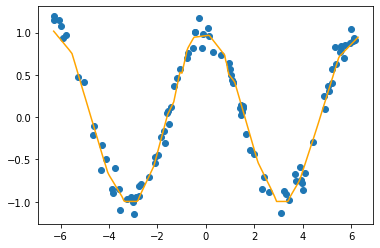

In [312]:
step = 300
xv = torch.linspace(-2 * np.pi, 2 * np.pi, step).unsqueeze(1).to(device)
yv = model(xv)

graph_validation_loader = DataLoader(validation_data, batch_size=100, shuffle=True)
x, y = next(iter(graph_validation_loader))
plt.scatter(x.cpu().detach().numpy(), y.cpu().detach().numpy())
plt.plot(xv.cpu().detach().numpy(), yv.cpu().detach().numpy(), color="Orange")